## Fault Tolerance in LangGraph

In [9]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict
import time

In [10]:
# 1. Define the state
class CrashState(TypedDict):

    input: str
    step1: str
    step2: str
    step3: str
    

In [11]:
# 2. Define steps
def step_1(state: CrashState) -> CrashState:
    print("Step 1 executed")
    return {"step1": "done", "input": state['input']}

def step_2(state: CrashState) -> CrashState:
    print("Step 2 hanging.... now manually interrupt from the notebook toolbar (STOP Button)")
    time.sleep(30)  # simulating long-running hang
    return {"step2": "done"}

def step_3(state: CrashState) -> CrashState:
    print("Step 3 executed")
    return {"step3": "done"}

In [12]:
# Build the graph
builder = StateGraph(CrashState)

builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)

builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

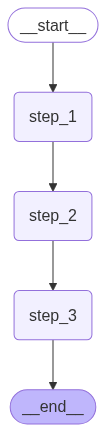

In [13]:
graph

In [14]:
try: 
    print("Running graph: Please manulayy interrupt during Step 2...")
    graph.invoke({"input": "start"}, config={"configurable": {"thread_id": "thread_1"}})
except KeyboardInterrupt:
    print("Kernel manually interrupted (crash simulation).")


Running graph: Please manulayy interrupt during Step 2...
Step 1 executed
Step 2 hanging.... now manually interrupt from the notebook toolbar (STOP Button)
Kernel manually interrupted (crash simulation).


In [15]:
graph.get_state({"configurable": {"thread_id": "thread_1"}})

StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step_2',), config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f097daa-64e8-6d6b-8001-68e0e7f81d86'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-09-22T17:36:19.731575+00:00', parent_config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f097daa-64e5-67c7-8000-c0e8b86fd56a'}}, tasks=(PregelTask(id='b775aaaf-184b-cec1-2b3c-1d3e6413dcd7', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [18]:
state_history = graph.get_state_history({"configurable": {"thread_id": "thread_1"}})
for i, state in enumerate(state_history):
    print(f"Step {i} state: {state}")

Step 0 state: StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step_2',), config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f097daa-64e8-6d6b-8001-68e0e7f81d86'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-09-22T17:36:19.731575+00:00', parent_config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f097daa-64e5-67c7-8000-c0e8b86fd56a'}}, tasks=(PregelTask(id='b775aaaf-184b-cec1-2b3c-1d3e6413dcd7', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(), state=None, result=None),), interrupts=())
Step 1 state: StateSnapshot(values={'input': 'start'}, next=('step_1',), config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f097daa-64e5-67c7-8000-c0e8b86fd56a'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-09-22T17:36:19.730187+00:00', parent_config={'configurable': {'thread_id': 'thread_1',

In [22]:
# 6. Re-run to show fault-tolerant resume
final_state = graph.invoke(None, {"configurable": {"thread_id": "thread_1"}})
print("\nFinal State:", final_state)

Step 2 hanging.... now manually interrupt from the notebook toolbar (STOP Button)
Step 3 executed

Final State: {'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}


In [23]:
graph.get_state({"configurable": {"thread_id": "thread_1"}})

StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}, next=(), config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f097db6-3b3a-6284-8003-fe73239a95f5'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-09-22T17:41:37.483404+00:00', parent_config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f097db6-3b35-6896-8002-6e9e720ddc38'}}, tasks=(), interrupts=())

In [24]:
state_history = graph.get_state_history({"configurable": {"thread_id": "thread_1"}})
for i, state in enumerate(state_history):
    print(f"Step {i} state: {state}")

Step 0 state: StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}, next=(), config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f097db6-3b3a-6284-8003-fe73239a95f5'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-09-22T17:41:37.483404+00:00', parent_config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f097db6-3b35-6896-8002-6e9e720ddc38'}}, tasks=(), interrupts=())
Step 1 state: StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done'}, next=('step_3',), config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f097db6-3b35-6896-8002-6e9e720ddc38'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-09-22T17:41:37.481501+00:00', parent_config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f097daa-64e8-6d6b-8001-68e0e7f81d86'}}, tasks=(PregelTa